In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anti-uav-yolo-1024/valid/labels/01028.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01484.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00588.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00286.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00080.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01279.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00440.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02557.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01936.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00733.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00134.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01466.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00709.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00372.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01850.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02017.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02363.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01

In [2]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

In [3]:
from sklearn import preprocessing


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

import glob
import cv2
from PIL import Image

In [4]:
BASE_PATH = "/kaggle/input/anti-uav-yolo-1024/train"
TXT_PATH = glob.glob("/kaggle/input/anti-uav-yolo-1024/train/labels/*.txt")
IMG_PATH = glob.glob("/kaggle/input/anti-uav-yolo-1024/train/images/*.jpg")
IMG_PATH2 = glob.glob("/kaggle/input/anti-uav-yolo-1024/valid/images/*.jpg")

In [5]:
def convert_format(box, iwidth=800, iheight=800):
    x_center, y_center, width, height = box
    
    x_min = int((x_center - width / 2) * iwidth)
    y_min = int((y_center - height / 2) * iheight)
    x_max = int((x_center + width / 2) * iwidth)
    y_max = int((y_center + height / 2) * iheight)
    
    return [x_min, y_min, x_max, y_max]

In [6]:
import os
from PIL import Image

train_image = []
train_image_path = []
train_image_id = []
train_annotation = []

for img_path in IMG_PATH:
    # Extract image ID
    image_id = os.path.basename(img_path).split('.')[0]
   

    # Construct path for annotation file
    annotation_path = os.path.join("/kaggle/input/anti-uav-yolo-1024/train/labels/", image_id + ".txt")

    # Check if annotation file exists
    if os.path.exists(annotation_path):
        # Check if annotation file is not empty
        if os.path.getsize(annotation_path) > 0:
            Load_image = Image.open(img_path).convert('RGB')
            nmpy_img = Load_image.resize((800, 800))
            train_image.append(np.asarray(nmpy_img))
            train_image_path.append(img_path)
            train_image_id.append(image_id)

            # Read annotation file
            with open(annotation_path) as f:
                lines = f.readlines()
                tmp_lst = lines[0].split(' ')
                startX = float(tmp_lst[1])
                startY = float(tmp_lst[2])
                endX = float(tmp_lst[3])
                endY = float(tmp_lst[4])

                train_annotation.append(convert_format([startX, startY, endX, endY]))
        else:
            print(f"Annotation file is empty for image: {img_path}")
    else:
        print(f"Annotation file not found for image: {img_path}")

print("Images and annotations processed successfully.")

Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00639.jpg
Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00724.jpg
Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00579.jpg
Images and annotations processed successfully.


In [7]:
valid_image = []
valid_image_path = []
valid_image_id = []
valid_annotation = []

for img_path in IMG_PATH2:
    # Extract image ID
    image_id = os.path.basename(img_path).split('.')[0]
   

    # Construct path for annotation file
    annotation_path = os.path.join("/kaggle/input/anti-uav-yolo-1024/valid/labels/", image_id + ".txt")

    # Check if annotation file exists
    if os.path.exists(annotation_path):
        # Check if annotation file is not empty
        if os.path.getsize(annotation_path) > 0:
            Load_image = Image.open(img_path).convert('RGB')
            nmpy_img = Load_image.resize((800, 800))
            valid_image.append(np.asarray(nmpy_img))
            valid_image_path.append(img_path)
            valid_image_id.append(image_id)

            # Read annotation file
            with open(annotation_path) as f:
                lines = f.readlines()
                tmp_lst = lines[0].split(' ')
                startX = float(tmp_lst[1])
                startY = float(tmp_lst[2])
                endX = float(tmp_lst[3])
                endY = float(tmp_lst[4])

                valid_annotation.append(convert_format([startX, startY, endX, endY]))
        else:
            print(f"Annotation file is empty for image: {img_path}")
    else:
        print(f"Annotation file not found for image: {img_path}")

print("Images and annotations processed successfully.")

Images and annotations processed successfully.


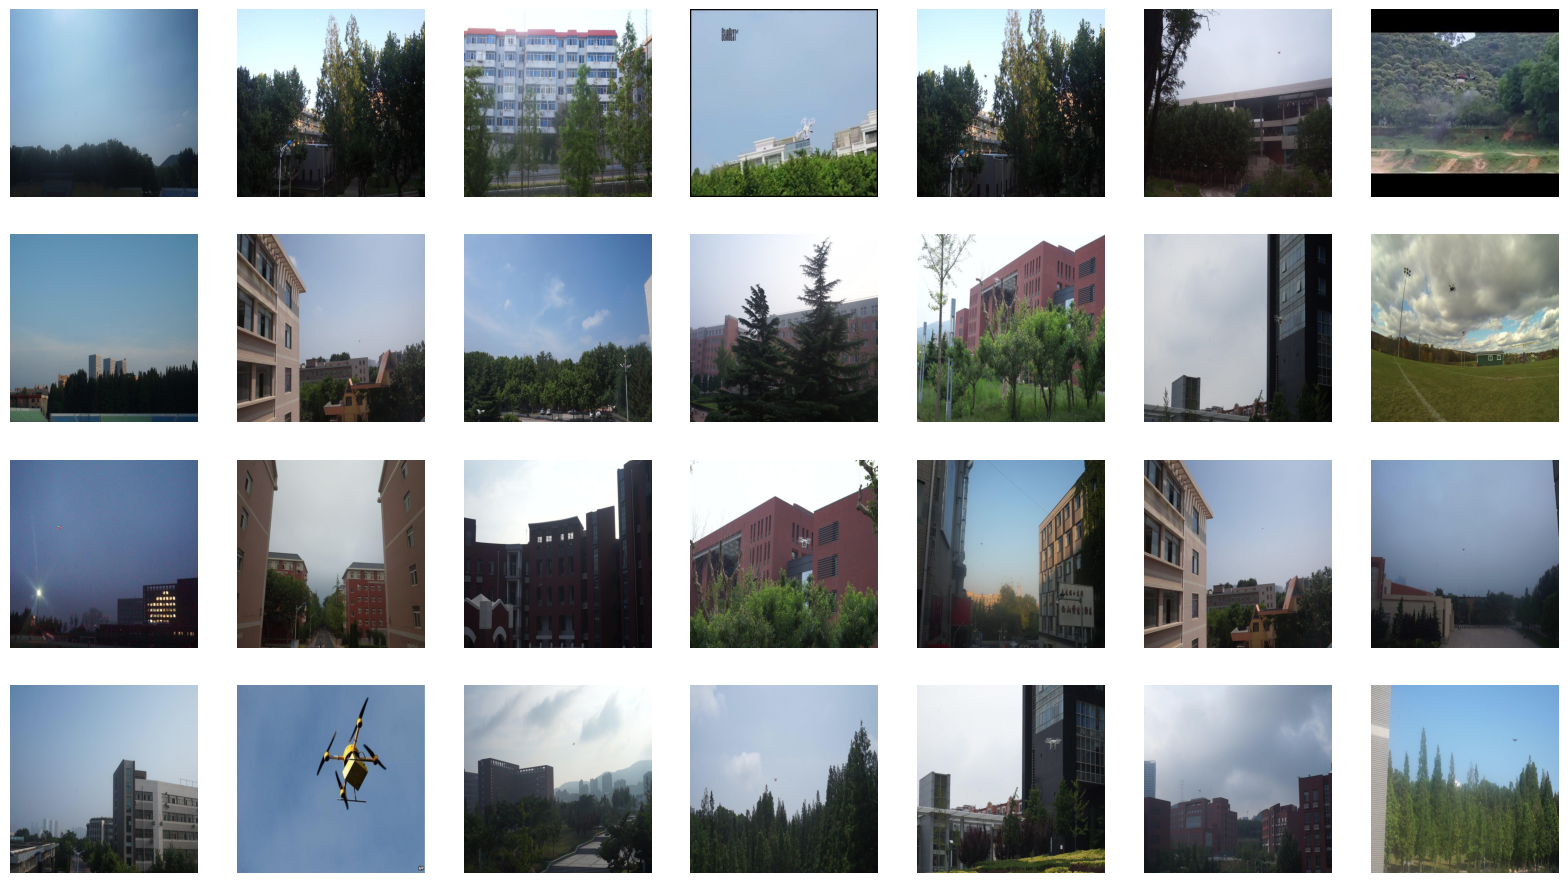

In [8]:
plt.figure(figsize=(20, 20))

for i in range(28):
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(train_image[i].astype("uint8"))
    plt.axis("off")

In [9]:
df = pd.DataFrame()
df['boxes'] = train_annotation
df['img_path'] = train_image_path
df['labels'] = 'drone'
df['img_id'] = train_image_id

df2 = pd.DataFrame()
df2['boxes'] = valid_annotation
df2['img_path'] = valid_image_path
df2['labels'] = 'drone'
df2['img_id'] = valid_image_id

In [10]:
import numpy as np
from sklearn import preprocessing

enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['labels'])
df['labels'] = np.stack([df['labels'][i]+1 for i in range(len(df['labels']))])

df2['labels'] = enc.fit_transform(df2['labels'])
df2['labels'] = np.stack([df2['labels'][i]+1 for i in range(len(df2['labels']))])

In [11]:
import numpy as np

# Assuming df['boxes'] contains arrays/lists of coordinates
# Create separate columns for 'xmin', 'ymin', 'xmax', 'ymax'
df[['xmin', 'ymin', 'xmax', 'ymax']] = np.stack(df['boxes'].apply(lambda x: np.array(x)).values)

# Drop the 'boxes' column
df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(float)
df['ymin'] = df['ymin'].astype(float)
df['xmax'] = df['xmax'].astype(float)
df['ymax'] = df['ymax'].astype(float)

df2[['xmin', 'ymin', 'xmax', 'ymax']] = np.stack(df2['boxes'].apply(lambda x: np.array(x)).values)

# Drop the 'boxes' column
df2.drop(columns=['boxes'], inplace=True)
df2['xmin'] = df2['xmin'].astype(float)
df2['ymin'] = df2['ymin'].astype(float)
df2['xmax'] = df2['xmax'].astype(float)
df2['ymax'] = df2['ymax'].astype(float)

In [12]:
df_removed_damaged1 = df.drop(df[(df.ymin > df.ymax) | (df.xmin > df.xmax)].index)
df_removed_damaged1

mask = (df['ymin'] >= 800) | (df['ymax'] >= 800) | (df['xmin'] >= 800) | (df['xmax'] >= 800)
# Drop rows where the condition is True
df_removed_damaged = df_removed_damaged1.drop(df[mask].index)

df2_removed_damaged1 = df2.drop(df2[(df2.ymin >= df2.ymax) | (df2.xmin >= df2.xmax)].index)
df2_removed_damaged1

mask1 = (df2['ymin'] >= 800) | (df2['ymax'] >= 800) | (df2['xmin'] >= 800) | (df2['xmax'] >= 800)
# Drop rows where the condition is True
df2_removed_damaged = df2_removed_damaged1.drop(df2[mask1].index)

In [13]:
train_ds=df_removed_damaged
val_ds=df2_removed_damaged
val_ds
zero_mask = (train_ds['xmin'] <= 0) & (train_ds['ymin'] <= 0) & (train_ds['ymax'] <= 0) & (train_ds['xmax'] <= 0)
train_ds = train_ds[~zero_mask]
zero_mask2 = (val_ds['xmin'] <= 0) & (val_ds['ymin'] <= 0) & (val_ds['ymax'] <= 0) & (val_ds['xmax'] <= 0)
val_ds=val_ds[~zero_mask2]
print(len(train_ds))
print(len(val_ds))
print(zero_mask)
train_ds


5180
2592
0       False
1       False
2       False
3       False
4       False
        ...  
5192    False
5193    False
5194    False
5195    False
5196    False
Length: 5180, dtype: bool


img_path  labels img_id   xmin  \
0     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  04168  442.0   
1     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  02371  231.0   
2     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  04377  366.0   
3     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  00767  450.0   
4     /kaggle/input/anti-uav-yolo-1024/train/images/...       1  02360  282.0   
...                                                 ...     ...    ...    ...   
5192  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  02956  382.0   
5193  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  04731  394.0   
5194  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  03358  122.0   
5195  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  04801   50.0   
5196  /kaggle/input/anti-uav-yolo-1024/train/images/...       1  00117  133.0   

       ymin   xmax   ymax  
0     549.0  453.0  558.0  
1     281.0  249.0  299.0  
2     297.0  375.0  305.0  
3     464.0  533.0  560.0  
4     275.0  303.0  297.0  
...     ...    ...    ...  
5192  478.0  394.0  494.0  
5193  480.0  407.0  491.0  
5194  557.0  149.0  577.0  
5195  401.0   62.0  407.0  
5196  411.0  489.0  684.0  

[5180 rows x 7 columns]

In [14]:
transforms_train = A.Compose([
    A.HorizontalFlip(),
    A.OneOf([
        A.ColorJitter(hue=0.1),
        A.Equalize(by_channels=False),
        A.FancyPCA(),
        A.GaussNoise(),
        A.ImageCompression(),
        A.ISONoise(),
        A.RandomGamma(),
        A.RandomToneCurve(),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15),
        A.AdvancedBlur(p=0.1)
    ]),
    ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', label_fields=['labels'], min_area=21))

transforms_valid = ToTensorV2()

In [15]:
class VOC_2010(torch.utils.data.Dataset):
    def __init__(self, df, imdir, transforms):
        self.df = df
        self.imdir = imdir
        self.imnames = df['img_id'].unique()
        self.transforms = transforms
    
    def __getitem__(self, idx):
        imname = self.imnames[idx]
        image = cv2.imread(os.path.join(self.imdir+imname+'.jpg'), cv2.IMREAD_COLOR)
        image= cv2.resize(image, (800, 800))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #.astype(np.float32)
                        
        # Augmentation 
        mask = self.df['img_id'] == imname
        bboxes = np.array(self.df[mask][['xmin', 'ymin', 'xmax', 'ymax']])
        labels = np.array((self.df[mask]['labels']))
        transformed = self.transforms(image=image, bboxes=bboxes, labels=labels)
                        
        # Output for the model 
        image = transformed['image'] 
        bboxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float16)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        if len(bboxes) == 0:
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros(0, dtype=torch.int64)
                 }
        else:
                target = {'boxes': bboxes, 'labels': labels}
                        
        # Normalization
        image = image/255
               
        return image, target
    
    
    def __len__(self):
        return len(self.imnames)

In [16]:
"""class VOC_2010(torch.utils.data.Dataset):
    def __init__(self, dframe, imdir, transforms):
        self.df = dframe
        self.imdir = imdir
        self.imnames = df['img_id'].unique()
        self.transforms = transforms
    
    def __getitem__(self, idx):
        imname = self.imnames[idx]
        image = cv2.imread(os.path.join(self.imdir+imname+'.jpg'), cv2.IMREAD_COLOR)
        image= cv2.resize(image, (800, 800))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #.astype(np.float32)
                        
        # Augmentation 
        mask = self.df['img_id'] == imname
        bboxes = np.array(self.df[mask][['xmin', 'ymin', 'xmax', 'ymax']])
        labels = np.array((self.df[mask]['labels']))
        transformed = self.transforms(image=image, bboxes=bboxes, labels=labels)
                        
        # Output for the model 
        image = transformed['image'] 
        bboxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float16)
        labels = torch.as_tensor(labels, dtype=torch.int64)        
        target = {'boxes': bboxes, 'labels': labels}
                        
        # Normalization
        image = image/255
               
        return image, target
    
    
    def __len__(self):
        return len(self.imnames)"""

"class VOC_2010(torch.utils.data.Dataset):\n    def __init__(self, dframe, imdir, transforms):\n        self.df = dframe\n        self.imdir = imdir\n        self.imnames = df['img_id'].unique()\n        self.transforms = transforms\n    \n    def __getitem__(self, idx):\n        imname = self.imnames[idx]\n        image = cv2.imread(os.path.join(self.imdir+imname+'.jpg'), cv2.IMREAD_COLOR)\n        image= cv2.resize(image, (800, 800))\n        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #.astype(np.float32)\n                        \n        # Augmentation \n        mask = self.df['img_id'] == imname\n        bboxes = np.array(self.df[mask][['xmin', 'ymin', 'xmax', 'ymax']])\n        labels = np.array((self.df[mask]['labels']))\n        transformed = self.transforms(image=image, bboxes=bboxes, labels=labels)\n                        \n        # Output for the model \n        image = transformed['image'] \n        bboxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float16)\

In [17]:
img_dir1 = "/kaggle/input/anti-uav-yolo-1024/train/images/"
img_dir2 = "/kaggle/input/anti-uav-yolo-1024/valid/images/"
train_data = VOC_2010(train_ds, img_dir1, transforms_train)
valid_data = VOC_2010(val_ds, img_dir2, transforms_valid)

print('Training sample size', len(train_data))
print('Validation sample size', len(valid_data))

Training sample size 5180
Validation sample size 2592


In [18]:
"""train_whs = torch.as_tensor(np.array(train_ds, dtype=torch.float16)

valid_whs = torch.as_tensor(np.array(val_ds, dtype=torch.float16)

train_sampler = WeightedRandomSampler(train_whs, len(train_whs))
valid_sampler = WeightedRandomSampler(valid_whs, len(valid_whs))"""

'train_whs = torch.as_tensor(np.array(train_ds, dtype=torch.float16)\n\nvalid_whs = torch.as_tensor(np.array(val_ds, dtype=torch.float16)\n\ntrain_sampler = WeightedRandomSampler(train_whs, len(train_whs))\nvalid_sampler = WeightedRandomSampler(valid_whs, len(valid_whs))'

In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = DataLoader(
    train_data, 
    batch_size=16,
    collate_fn=collate_fn
    )

valid_dataloader = DataLoader(
    valid_data, 
    batch_size=8,
    collate_fn=collate_fn
    )

# DataLoader for measuring metrics.  
metrics_dataloader = DataLoader(
    valid_data,
    batch_size=8,
    collate_fn=collate_fn
)

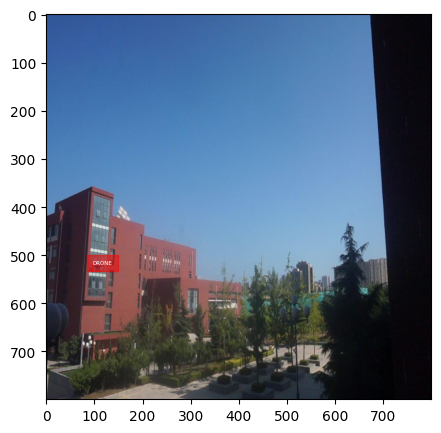

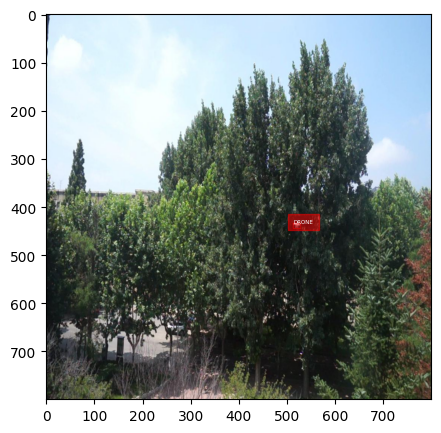

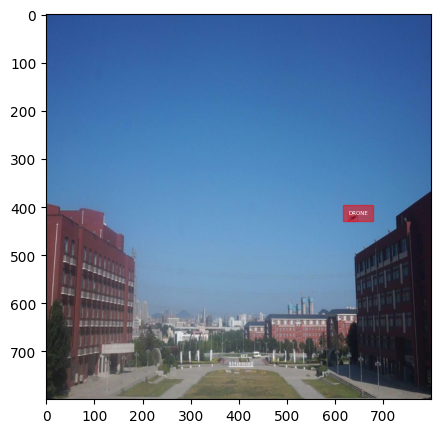

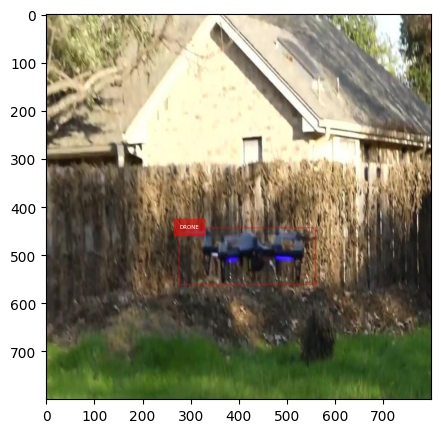

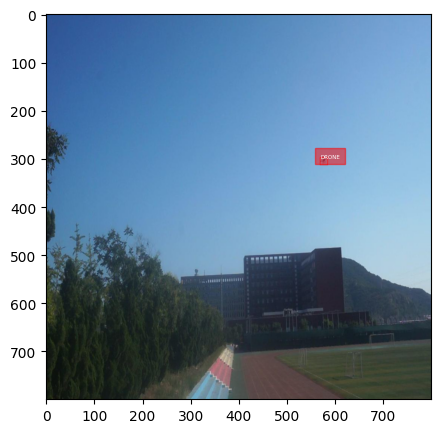

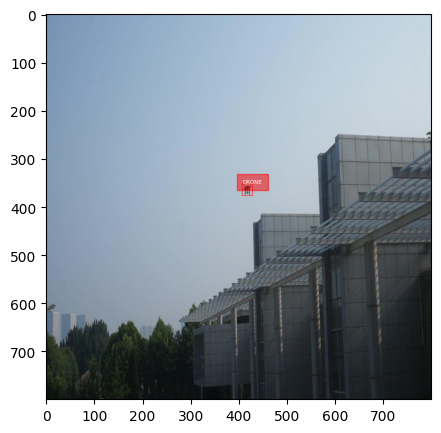

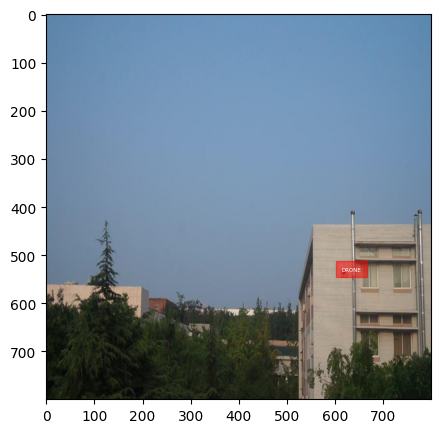

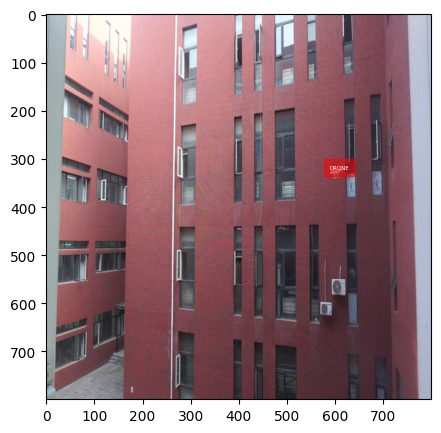

In [20]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data):
    img = next(iter(data))
    for num in range(8):
        image = image_convert(img[0][num])
        image = np.ascontiguousarray(image)
        bboxes = img[1][num]['boxes'].numpy()
        labels = img[1][num]['labels']
        fig, ax = plt.subplots(figsize=(5,5))
        
        for i, bbox in enumerate(bboxes):
            xmin, ymin, xmax, ymax = (int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3]))
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), thickness=1)
            text = ax.text(xmin, ymin, f'DRONE', fontsize=4, color='w')
            text.set_bbox(dict(facecolor='r', alpha=0.5, edgecolor='r'))
        plt.imshow(image);
    
plot_img(valid_dataloader)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We use a pre-trained Resnet-50 model.
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
num_classes = 1

# Let's get the number of input features for the classifier.
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Let's replace the classifier with a new one.
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)
print(f'\nDevice: {device}, number of classes: {num_classes}, pretrained model: Resnet-50')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 171MB/s] 



Device: cuda, number of classes: 1, pretrained model: Resnet-50


In [22]:
import torch.optim as optim
from tqdm import tqdm

In [23]:
# Model training function.
def calc(model, optimizer, dataloader, scheduler):
    scheduler = scheduler
    model.train()
    def sub_calc(dataloader, scheduler, is_train=True, mode='train'):
        loss, indx = [], 0
        torch.set_grad_enabled(is_train)
    
        for i, (images, targets) in tqdm(enumerate(dataloader)):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            #targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss.append(losses.item())
            if is_train:
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()
        scheduler.step() if is_train else scheduler
        return round(np.mean(loss), 4)
    return sub_calc(train_dataloader, scheduler, True, 'train'), sub_calc(valid_dataloader, scheduler, False, 'valid')

In [24]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.7, weight_decay=0.0005)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0003, max_lr=0.01,step_size_up=5,mode="exp_range",gamma=0.85)

In [25]:
# Start training.
num_epochs = 20
total_train_loss = []
total_valid_loss = []
total_epochs = []
best_model = 1000
#start = datetime.now()
for epoch in range(num_epochs):
    print(f' {epoch+1} epoch out of {num_epochs}.\
    ', end='\r')
    train_loss, valid_loss = calc(model, optimizer, train_dataloader, scheduler)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {valid_loss}')
    total_train_loss.append(train_loss)
    total_valid_loss.append(valid_loss)
    total_epochs.append(epoch+1)
    if valid_loss < best_model:
        best_model = valid_loss
        path_best = f"ep{str(epoch+1)}_best_model.pth"
        torch.save(model.state_dict(), path_best)
    #clear_output(wait=True)
    print('')
#end = datetime.now()
#print("Runtime Faster RCNN:",str(end-start)[:7])

324it [07:58,  1.48s/it]
324it [02:47,  1.94it/s]


Epoch 1/20, Train Loss: 0.219, Validation Loss: 0.1737



324it [07:54,  1.46s/it]
324it [02:49,  1.91it/s]


Epoch 2/20, Train Loss: 0.1258, Validation Loss: 0.1177



324it [07:53,  1.46s/it]
324it [02:48,  1.92it/s]


Epoch 3/20, Train Loss: 0.1011, Validation Loss: 0.1037



324it [07:55,  1.47s/it]
324it [02:49,  1.91it/s]


Epoch 4/20, Train Loss: 0.0897, Validation Loss: 0.1016



324it [07:54,  1.46s/it]
324it [02:47,  1.94it/s]


Epoch 5/20, Train Loss: 0.0814, Validation Loss: 0.1013



324it [07:55,  1.47s/it]
324it [02:47,  1.93it/s]


Epoch 6/20, Train Loss: 0.0755, Validation Loss: 0.1003



324it [07:53,  1.46s/it]
324it [02:47,  1.94it/s]


Epoch 7/20, Train Loss: 0.0698, Validation Loss: 0.1121



324it [07:54,  1.46s/it]
324it [02:49,  1.91it/s]


Epoch 8/20, Train Loss: 0.0661, Validation Loss: 0.1093



324it [02:47,  1.94it/s]


Epoch 9/20, Train Loss: 0.0627, Validation Loss: 0.1122



324it [07:53,  1.46s/it]
324it [02:56,  1.84it/s]


Epoch 10/20, Train Loss: 0.0611, Validation Loss: 0.1145



324it [07:55,  1.47s/it]
324it [02:50,  1.90it/s]


Epoch 11/20, Train Loss: 0.0598, Validation Loss: 0.1101



324it [07:54,  1.47s/it]
324it [02:47,  1.94it/s]


Epoch 12/20, Train Loss: 0.0596, Validation Loss: 0.1138



324it [07:54,  1.46s/it]
324it [02:47,  1.93it/s]


Epoch 13/20, Train Loss: 0.0584, Validation Loss: 0.1211



324it [07:53,  1.46s/it]
324it [02:48,  1.92it/s]


Epoch 14/20, Train Loss: 0.0591, Validation Loss: 0.1161



324it [07:53,  1.46s/it]
324it [02:48,  1.93it/s]


Epoch 15/20, Train Loss: 0.0577, Validation Loss: 0.1188



324it [07:53,  1.46s/it]
324it [02:47,  1.93it/s]


Epoch 16/20, Train Loss: 0.0573, Validation Loss: 0.1174



324it [07:53,  1.46s/it]
324it [02:47,  1.94it/s]


Epoch 17/20, Train Loss: 0.0554, Validation Loss: 0.1182



324it [07:53,  1.46s/it]
324it [02:47,  1.93it/s]


Epoch 18/20, Train Loss: 0.0554, Validation Loss: 0.1192



324it [07:53,  1.46s/it]
324it [02:49,  1.91it/s]


Epoch 19/20, Train Loss: 0.0541, Validation Loss: 0.1229



324it [07:54,  1.46s/it]
324it [02:53,  1.87it/s]

Epoch 20/20, Train Loss: 0.0536, Validation Loss: 0.1211



In [26]:
!pip install pycocotools
! pip install -U ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 11.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6080 sha256=ddef50176cd6605591edd71444bf2c926151398827228a412a2162899ea56eab
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [27]:
from torchmetrics.detection import MeanAveragePrecision
metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
metric.to(device)

MeanAveragePrecision()

In [28]:
MeanAveragePrecision()
threshold=0.25
iou_threshold=0.75
def preprocess_bbox(prediction):
    
    """Non-max suppression is the final step of these object detection algorithms and is 
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""
    
    processed_bbox={}
    
    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)
            
    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]
    
    return processed_bbox

In [29]:
model.eval()
with torch.no_grad():
    """for imgs,targets in valid_data_loader:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        #targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]"""
    for i, (imgs, targets) in tqdm(enumerate(valid_dataloader)):
            imgs = list(image.to(device) for image in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            predictions=model(imgs)
        
            results=[]
            for prediction in predictions:
                results.append(preprocess_bbox(prediction))
                #results.append(prediction)
            metric.update(results,targets)
results=metric.compute()

324it [02:59,  1.81it/s]


In [30]:
fast_mean_ap=results["map"].item()
fast_mean_ap_50=results["map_50"].item()
fast_mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {fast_mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {fast_mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {fast_mean_ap_75:.4f}")

Mean Average Precision[0.5:0.95:0.05] : 0.5620
Mean Average Precision @ 0.5          : 0.8841
Mean Average Precision @ 0.75         : 0.6355


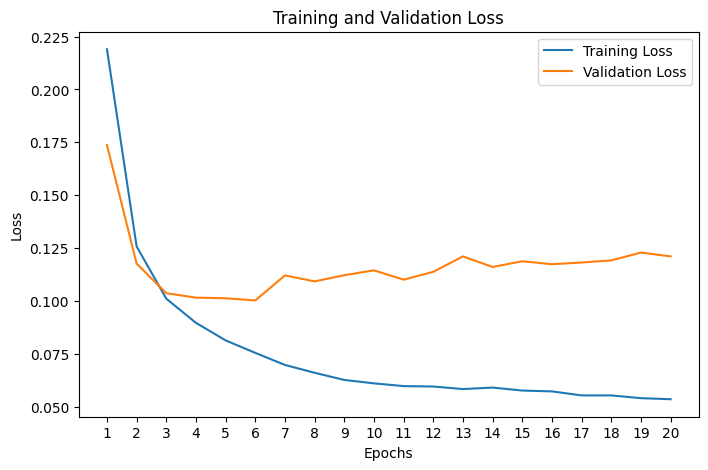

In [34]:
"""plt.plot(total_epochs, total_train_loss, label='Train')
plt.plot(total_epochs, total_valid_loss, label='Valid', linestyle='--')
plt.grid(True)
plt.legend(loc=1, frameon=True, edgecolor='red', facecolor='#DEFFF2')
plt.show();"""

import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(total_epochs,total_train_loss, label='Training Loss')
plt.plot(total_epochs,total_valid_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xticks(total_epochs)
plt.legend()
#plt.grid(True)
plt.show()

In [35]:
# Threshold for low confidence block filter.  
PIP_th = 0.5

# Threshold for the non-maximum block suppression filter (torch.nms).  
IOU_th = 0.7

In [36]:
# Function for filtering blocks with a low level of confidence. 
def filt_box(f_data, pip_th):
    data_p = f_data.copy()
    main_lst = []
    
    for idx, val in enumerate(f_data['scores']):
        if val > pip_th:
            main_lst.append(idx)
    for i in list(data_p.keys()):
        data_p[i] = data_p[i][main_lst]
    return data_p

# Function for non-maximum block suppression (Torch.nms).  
def filt_nms(f_data, iou_th):
    main_idx = torchvision.ops.nms(f_data['boxes'], f_data['scores'], iou_th)
    final_pr = f_data

    for i in list(f_data.keys()):
        final_pr[i] = final_pr[i][main_idx]
    return final_pr


# Filtering, prediction and data management function for mAP.  
def proc_p(model, img, pip_th, iou_th, num, images=0):
    if images == 0:
        model = model.to('cpu')
        model.eval()
        with torch.no_grad():
            model_p = model(img[0])
        f_pip = filt_box(model_p[num], pip_th)
        f_pred = filt_nms(f_pip, iou_th)
        return f_pred['boxes'], f_pred['labels'], f_pred['scores']*100
    else:
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            model_p = model(images)
        model_p = list({key: val.to('cpu') for key, val in pred.items()} for pred in model_p)
        f_pip = list(filt_box(pred, 0.45) for pred in model_p)
        f_pred = list(filt_nms(pred, 7) for pred in f_pip)
        return f_pred

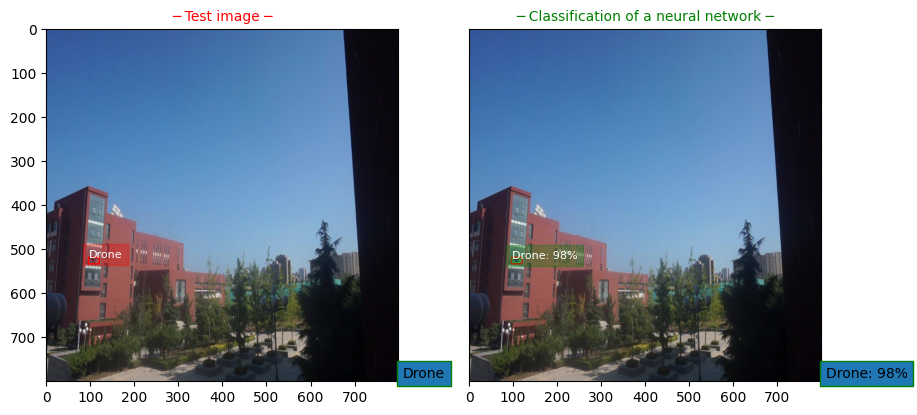

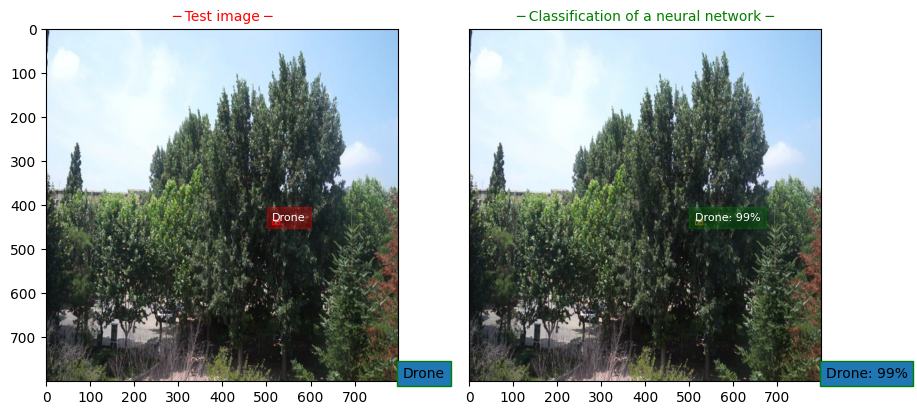

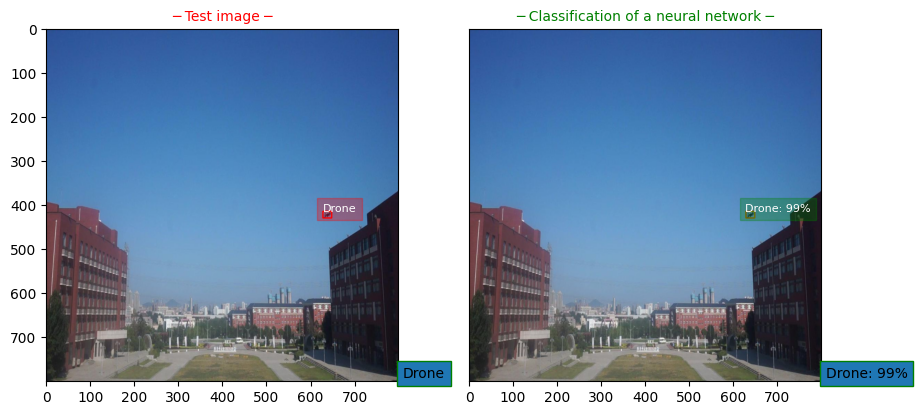

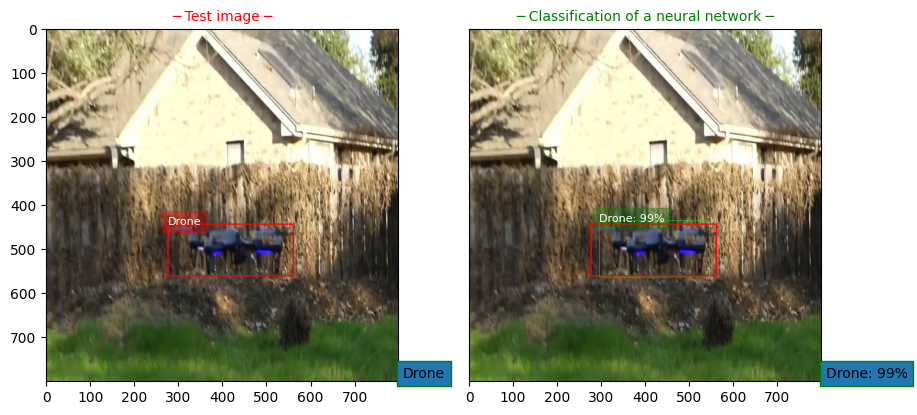

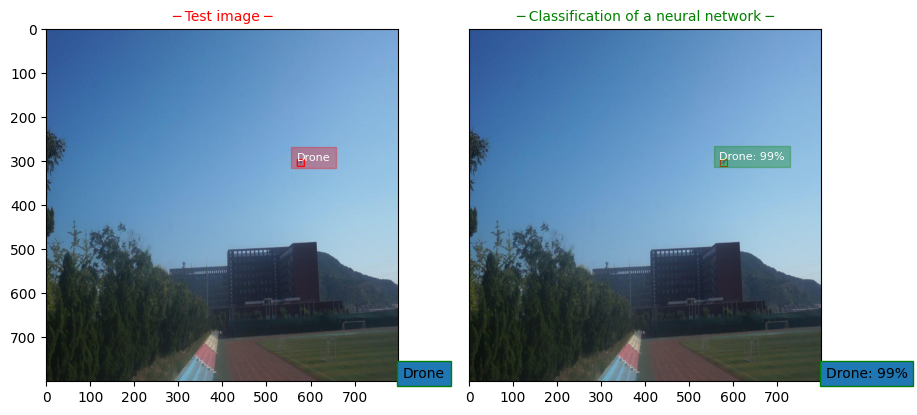

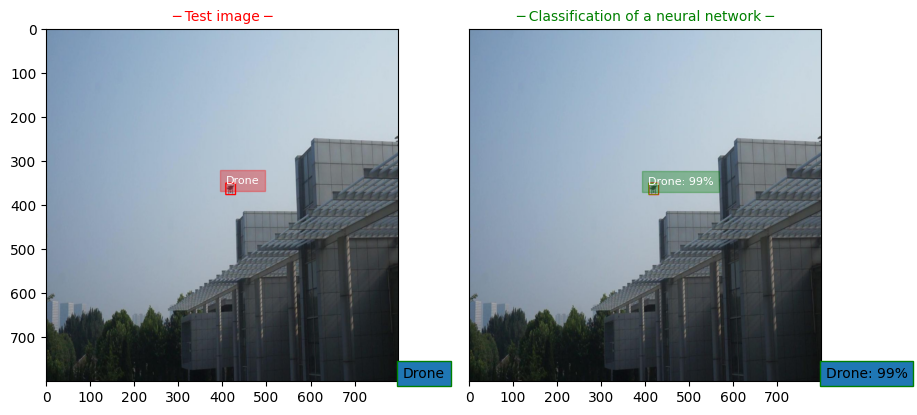

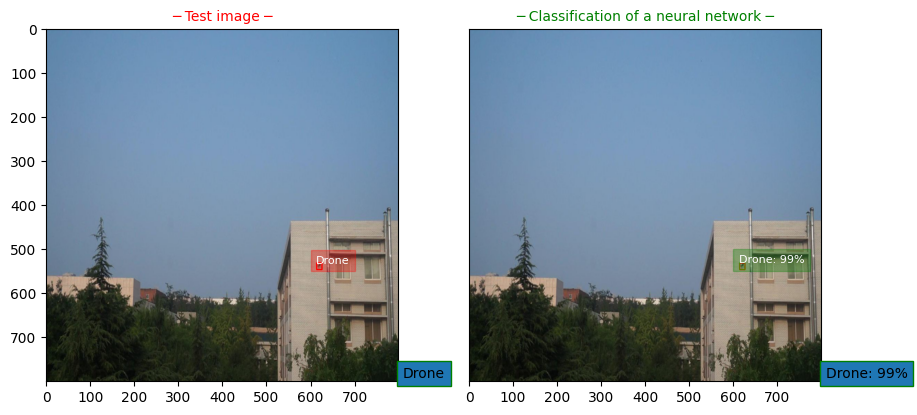

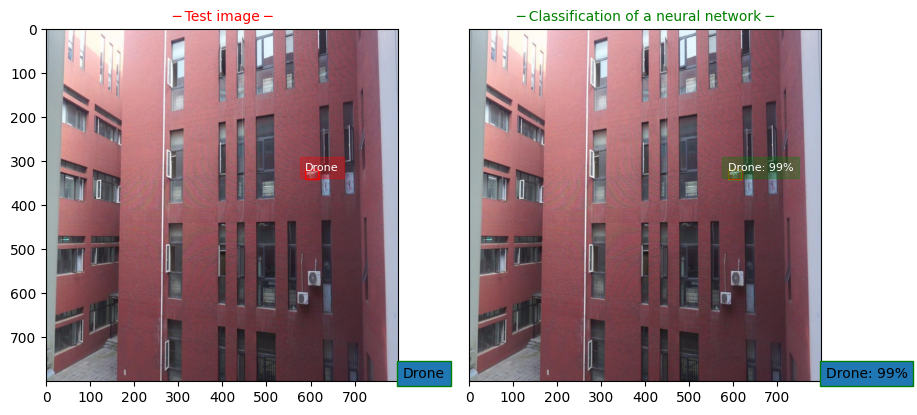

In [37]:
# Construction of drawings. 
def pict_predict(model,data, batch):
    img = next(iter(data))
    for num in range(batch):
        image = image_convert(img[0][num])
        image = np.ascontiguousarray(image)
        bboxes = img[1][num]['boxes'].numpy()
        labels = img[1][num]['labels']
        bboxes_p, labels_p, scores_p = proc_p(model, img, PIP_th, IOU_th, num, 0)
        iter_box=[]
        iter_box.append(bboxes)
        iter_box.append(bboxes_p)
        fig, axes = plt.subplots(1, 2, figsize=(10,7))
        txt, txt_p = [], []
        
        for n in range(2):
            for i, vol in enumerate(iter_box[n]):
                xmin, ymin, xmax, ymax = (int(vol[0]), int(vol[1]), int(vol[2]), int(vol[3]))
                if n == 0:
                    coler, clr,t_ness = (255,0,0), 'r', 2
                    txt.append('Drone')
                    text = axes[n].text(xmin, ymin, f'Drone', fontsize=8, color='w')
                if n == 1:
                    coler, clr, t_ness = (0,255,0), 'g', 1
                    txt_p.append(f"Drone: {int(scores_p[i])}%")
                    text = axes[n].text(xmin, ymin, f'Drone: {int(scores_p[i])}%', fontsize=8, color='w')
                cv2.rectangle(image, (xmin, ymin), (xmax, ymax), coler, thickness=t_ness)
                text.set_bbox(dict(facecolor=clr, alpha=0.3, edgecolor=clr))
                
            x = str(sorted(txt))[1:-1].replace("'", "")
            xn  = x.replace(", ", "\n")
            y = str(sorted(txt_p))[1:-1].replace("'", "")
            yn  = y.replace(", ", "\n")
            if n == 0:
                axes[0].set_title('─ Test image ─',c=clr, fontsize=10)
                axes[0].text(image.shape[1]+10, image.shape[0]-9.3, xn, bbox={'edgecolor':'green'})
            else:
                axes[1].set_title("─ Classification of a neural network ─", c='g', fontsize=10)
                axes[1].text(image.shape[1]+10, image.shape[0]-9.3, yn, bbox={'edgecolor':'green'})
                plt.yticks([])
            
            axes[n].imshow(image)

pict_predict(model, valid_dataloader, 8)